In [1]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set() 
import jax
import jax.numpy as jnp
from jax.example_libraries.optimizers import adam
from jax.example_libraries import stax

## PCA

Read data

In [2]:
df = pd.read_parquet('./IDS2017/Final/Combined.parquet')
df = df.drop(columns=['Label'])
display(df)

,Total Length of Fwd Packets,Total Length of Bwd Packets,Bwd Packet Length Max,Bwd Packet Length Mean,Bwd Packet Length Std,Average Packet Size,Avg Bwd Segment Size,Fwd Header Length.1,Subflow Fwd Bytes,Subflow Bwd Bytes
0,12,0,0,0.0,0.0,9.000000,0.0,40,12,0
1,6,6,6,6.0,0.0,9.000000,6.0,20,6,6
2,6,6,6,6.0,0.0,9.000000,6.0,20,6,6
3,6,6,6,6.0,0.0,9.000000,6.0,20,6,6
4,12,0,0,0.0,0.0,9.000000,0.0,40,12,0
...,...,...,...,...,...,...,...,...,...,...
1336219,112,152,76,76.0,0.0,48.666668,76.0,80,112,152
1336220,84,362,181,181.0,0.0,122.000000,181.0,40,84,362
1336221,31,6,6,6.0,0.0,22.666666,6.0,64,31,6
1336222,192,256,128,128.0,0.0,60.000000,128.0,120,192,256


In [3]:
x = df.to_numpy()
col_mean = np.nanmean(x, axis=0)
inds = np.where(np.isnan(x))
x[inds] = np.take(col_mean, inds[1])
m = np.mean(x, 0)
s = np.std(x, 0)
x = (x-m)/s

In [4]:
u,s,vh = np.linalg.svd(x,full_matrices=False)
fi = vh.T
z = u@np.diag(s)

In [5]:
sns.scatterplot(
    data= pd.DataFrame(z),
    x=0,
    y=1,
    hue=2,
    alpha=0.5
)

<Axes: xlabel='0', ylabel='1'>

## Autoencoder

In [6]:
x = df.to_numpy()  

def vector_mse(y,yhat):
    return jnp.mean(jnp.square(y-yhat), axis=-1)

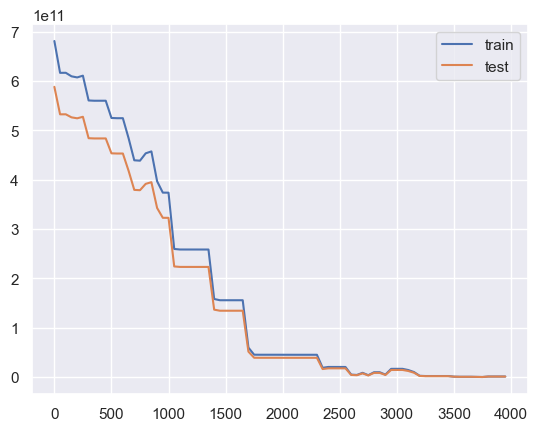

In [9]:
batch_size = 256
steps = 4000 
learning_rate = 0.001
train_split = int(0.7*x.shape[0])

k = jax.random.PRNGKey(42)

encoder = stax.serial(
    stax.Dense(16),
    stax.Relu,
    stax.Dense(8)
)

decoder = stax.serial(
    stax.Dense(16),
    stax.Relu,
    stax.Dense(x.shape[1])
)

nn = stax.serial(encoder, decoder)

init_nn, apply_nn = nn
opt_init, opt_update, get_params = adam(learning_rate)



@jax.jit 
def step(i, opt_state, x,y):
  params = get_params(opt_state)

  def loss(params,x,y):
      reconstruction = apply_nn(params,x) 
      return jnp.mean(vector_mse(y,reconstruction))

  g = jax.grad(loss)(params, x,y) 
  opt_state = opt_update(i, g, opt_state)
  step_loss = loss(get_params(opt_state),x,y)
  return opt_state, step_loss

@jax.jit
def test_loss(opt_state,x,y):
    params = get_params(opt_state) 
    reconstruction = apply_nn(params,x) 
    return jnp.mean(vector_mse(y,reconstruction))

_,params  = init_nn(k,(batch_size,x.shape[1])) 
opt_state = opt_init(params)

losses = []
test_losses = []
train_steps = []

for i in range(steps):
    idx = np.random.randint(0, train_split, size=batch_size)
    bx = x[idx,...]

    opt_state, step_loss = step(i, opt_state,bx,bx) 

    if i % 50 == 0:
        tx = x[train_split:,...]
        test_losses.append(test_loss(opt_state,tx,tx))
        train_steps.append(i) 
        losses.append(test_loss(opt_state,x[:train_split,...],x[:train_split,...]))

plt.plot(train_steps,losses,label='train')
plt.plot(train_steps,test_losses,label='test')
 
plt.legend()